Based on https://github.com/siyi-wind/TIP/tree/main/data/create_dvm_dataset.ipynb

In [1]:
import os
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.special import kl_div
from typing import Union, Tuple, Dict, Any
from scipy.spatial.distance import jensenshannon
from sklearn.model_selection import train_test_split

In [2]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")
SHIFTED_DIR = os.path.join(BASE, "shifted_dists")

In [3]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [4]:
def get_color_counts(df: pd.DataFrame) -> pd.DataFrame:
    color_counts = df["Color"].value_counts()
    color_percentages = df["Color"].value_counts(normalize=True) * 100

    # Optional: Combine into one DataFrame for clarity
    color_summary = pd.DataFrame({
        'Count': color_counts,
        'Percentage': color_percentages.round(3)
    })
    return color_summary

In [5]:
def plot_color_distributions(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    ax = df["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)

    # Customize the plot
    plt.title('Color distribution')
    plt.xlabel('Colors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

# Get color distribution of entire Dataset

In [6]:
physical_df = pd.read_csv(os.path.join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3134.0,1534.0,2118.0,5387.0
1,10_1$$2,3102.0,1551.0,2075.0,5433.0
2,10_1$$3,3122.0,1490.0,2122.0,5369.0
3,10_1$$4,3135.0,1513.0,2094.0,5353.0
4,10_1$$5,3105.0,1514.0,2077.0,5376.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [7]:
# Add jitter to physical dimensions so they aren't just labels
def add_jitter(x, jitter=50):
    return x + random.randint(-jitter, jitter)

random.seed(2022)
for attr in ['Wheelbase', 'Length', 'Width', 'Height']:
    physical_df[attr] = physical_df[attr].apply(add_jitter)

physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3152.0,1553.0,2111.0,5384.0
1,10_1$$2,3088.0,1587.0,2025.0,5476.0
2,10_1$$3,3128.0,1465.0,2119.0,5348.0
3,10_1$$4,3154.0,1511.0,2063.0,5316.0
4,10_1$$5,3094.0,1513.0,2029.0,5362.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [8]:
ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]
ad_data

/tmp/ipykernel_731143/3060315506.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]


,Adv_ID,Genmodel,Maker
0,10_1$$1,Arnage,Bentley
1,10_1$$2,Arnage,Bentley
2,10_1$$3,Arnage,Bentley
3,10_1$$4,Arnage,Bentley
4,10_1$$5,Arnage,Bentley
...,...,...,...
268250,97_1$$1,Sport,Westfield
268251,97_1$$2,Sport,Westfield
268252,99_1$$1,E10,Zenos
268253,99_1$$2,E10,Zenos


In [9]:
unique_cars = ad_data.drop_duplicates(subset=["Maker", "Genmodel"]).reset_index(drop=True)
unique_cars['Genmodel_ID'] = unique_cars['Adv_ID'].str.partition('$$')[0]
unique_cars['Car Name'] = unique_cars['Maker'].str.cat(unique_cars['Genmodel'], sep=' ')
unique_cars.drop(["Maker", "Genmodel", "Adv_ID"], axis=1, inplace=True)

unique_cars

,Genmodel_ID,Car Name
0,10_1,Bentley Arnage
1,10_2,Bentley Azure
2,10_3,Bentley Bentayga
3,10_4,Bentley Brooklands
4,10_5,Bentley Continental
...,...,...
911,96_7,Volvo V40
912,96_8,Volvo V40 Cross Country
913,96_9,Volvo V50
914,97_1,Westfield Sport


In [10]:
data_path = os.path.join(FEATURES, "data_df_unnorm.csv")
full_data_df = pd.read_csv(data_path)
full_data_df = full_data_df.loc[:, ~full_data_df.columns.str.contains('^Unnamed')]
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
0,10_1$$1,2018,4,2000.0,60000,21500,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45
1,10_1$$13,2018,4,2000.0,53444,21995,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0
2,10_1$$16,2017,12,2000.0,49700,29500,5.0,4.0,145000,4.4,Blue,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0
3,10_1$$18,2018,4,2000.0,75000,17995,5.0,4.0,145000,6.8,White,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90
4,10_1$$26,2017,5,2000.0,98000,17945,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [11]:
minimum_population = 100
values = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(codes[i][0])
    
full_data_df = full_data_df[full_data_df['Genmodel_ID'].isin(populated_codes)]

full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
25,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
26,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,Silver,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
27,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,Blue,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
28,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,White,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
29,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [12]:
full_data_df = full_data_df.merge(physical_df, on='Adv_ID')
full_data_df.dropna(inplace=True)
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,...,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint,Wheelbase,Height,Width,Length
0,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,2967.0,1750.0,2146.0,5106.0
1,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,2911.0,1656.0,2312.0,5228.0
2,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,2953.0,1688.0,2290.0,5120.0
3,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,3067.0,1834.0,2144.0,5120.0
4,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,3017.0,1712.0,2250.0,5168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176409,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2542.0,1540.0,1754.0,4428.0
176410,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,...,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2596.0,1446.0,1736.0,4558.0
176411,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2614.0,1482.0,1674.0,4504.0
176412,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,...,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,2706.0,1462.0,1764.0,4510.0


In [13]:
color_counts = get_color_counts(df=full_data_df)
color_counts

,Count,Percentage
Black,34005,19.276
Silver,29902,16.950
Blue,27793,15.754
Grey,26150,14.823
White,23369,13.247
Red,19514,11.061
Green,3500,1.984
Brown,2300,1.304
Yellow,2233,1.266
Orange,1966,1.114


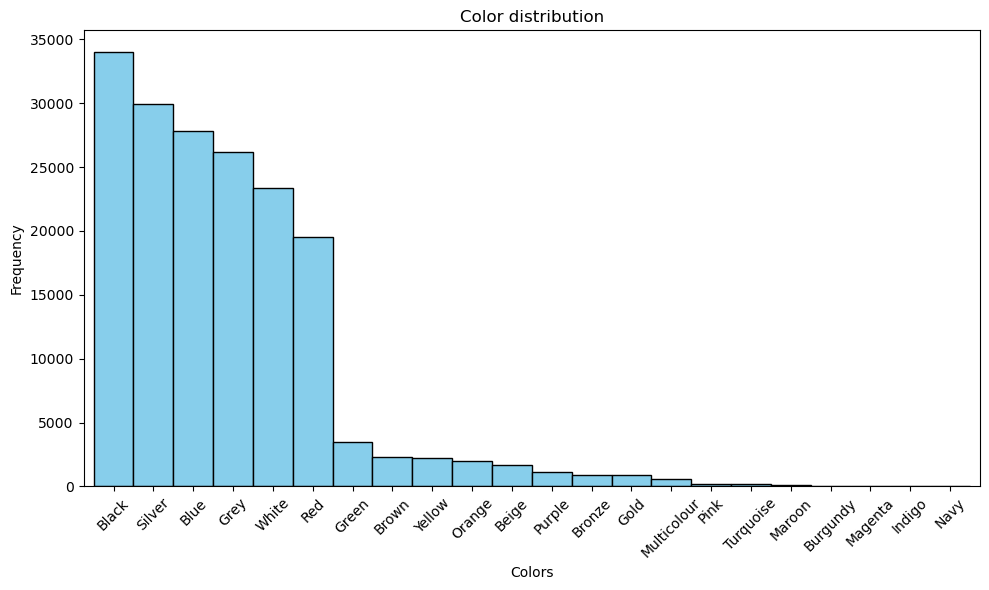

In [14]:
plot_color_distributions(df=color_counts)

## Plot Color Distribution of splits

In [15]:
train_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_train_noOH_all_views.csv'))
train_df['Color'] = train_df['Color'].map(color_coding)
val_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_val_noOH_all_views.csv'))
val_df['Color'] = val_df['Color'].map(color_coding)
test_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_test_noOH_all_views.csv'))
test_df['Color'] = test_df['Color'].map(color_coding)

In [16]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

print(f"Total Size: {train_df.shape[0] + val_df.shape[0] + test_df.shape[0]}")

(70565, 17)
(17642, 17)
(88207, 17)
Total Size: 176414


Relative Size between splits

### Training Split

In [17]:
train_color_counts = get_color_counts(df=train_df)
train_color_counts

,Count,Percentage
Black,13519,19.158
Silver,11977,16.973
Blue,11055,15.666
Grey,10509,14.893
White,9375,13.286
Red,7895,11.188
Green,1381,1.957
Brown,918,1.301
Yellow,895,1.268
Orange,786,1.114


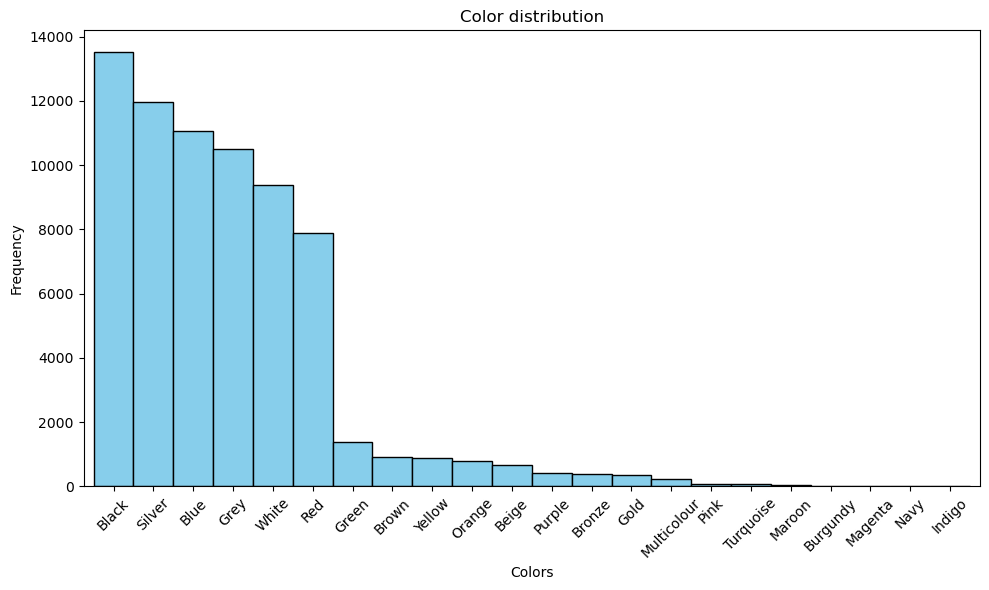

In [18]:
plot_color_distributions(df=train_color_counts)

### Validation Split

In [19]:
val_color_counts = get_color_counts(df=val_df)
val_color_counts

,Count,Percentage
Black,3469,19.663
Silver,3022,17.130
Blue,2823,16.002
Grey,2559,14.505
White,2318,13.139
Red,1843,10.447
Green,344,1.950
Yellow,235,1.332
Brown,233,1.321
Orange,202,1.145


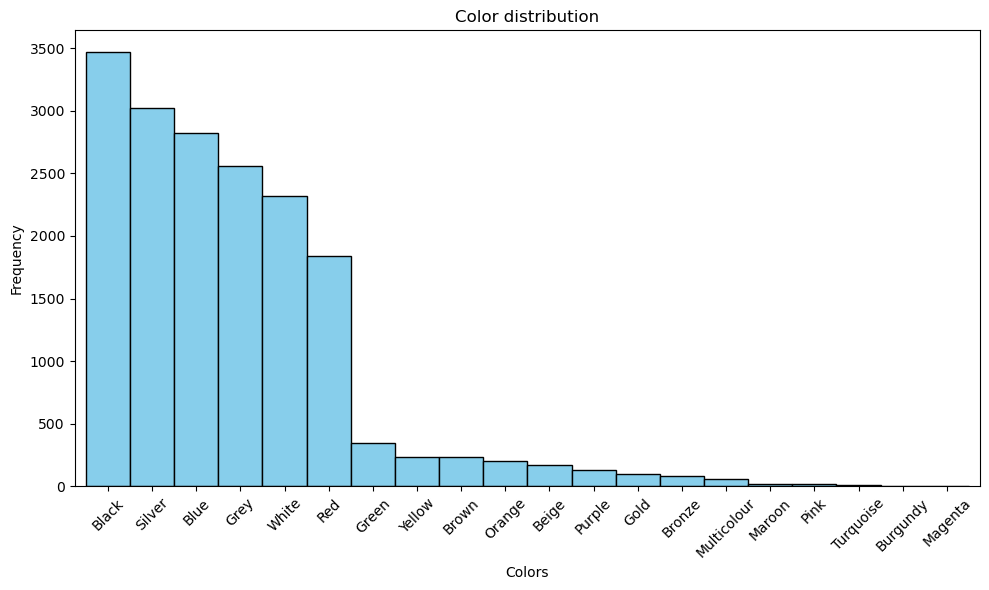

In [20]:
plot_color_distributions(df=val_color_counts)

### Test Split

In [21]:
test_color_counts = get_color_counts(df=test_df)
test_color_counts

,Count,Percentage
Black,17017,19.292
Silver,14903,16.895
Blue,13915,15.775
Grey,13082,14.831
White,11676,13.237
Red,9776,11.083
Green,1775,2.012
Brown,1149,1.303
Yellow,1103,1.250
Orange,978,1.109


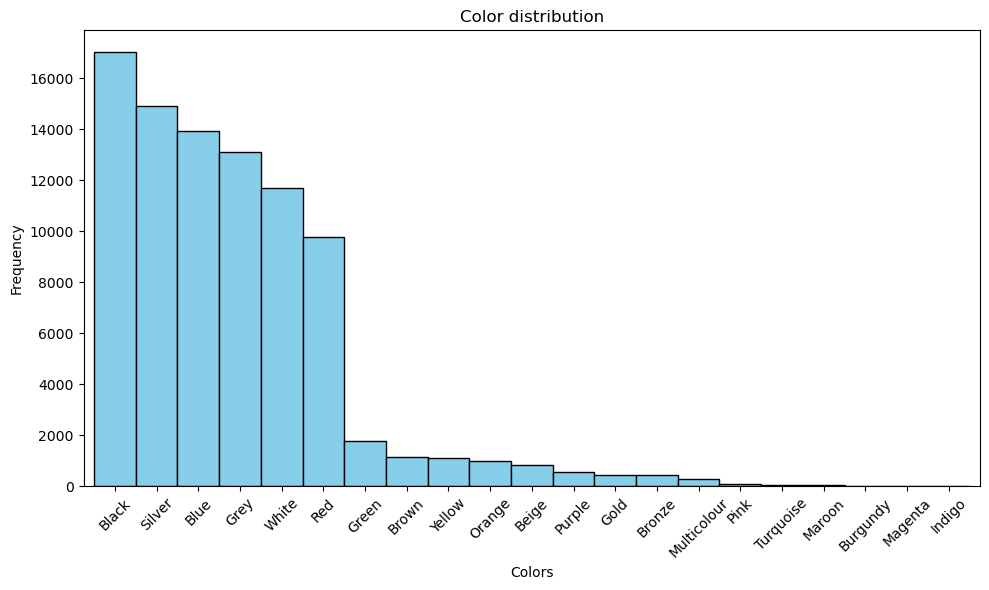

In [22]:
plot_color_distributions(df=test_color_counts)

## See if distributions are the same

In [23]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], feature: list[Any]) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(feature, train_dist.reindex(feature), label='Train', marker='o')
    plt.plot(feature, val_dist.reindex(feature), label='Validation', marker='s')
    plt.plot(feature, test_dist.reindex(feature), label='Test', marker='^')
    plt.xticks(rotation=45)
    plt.ylabel('Relative Frequency')
    plt.title('Color Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
def calc_KL(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> np.ndarray:
    kl = np.sum(kl_div(first_dist, second_dist))
    return kl

In [25]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    js = jensenshannon(first_dist, second_dist)
    return float(js)

In [26]:
colors = list(color_coding.values())

In [27]:
def fill_missing_vals(df: pd.DataFrame, fill_values: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    for fill in fill_values:
        if fill not in df:
            df[fill] = 0
    return df

In [28]:
train_dist = train_color_counts['Count'] / train_color_counts['Count'].sum()
val_dist = val_color_counts['Count'] / val_color_counts['Count'].sum()
test_dist = test_color_counts['Count'] / test_color_counts['Count'].sum()

#### Calculate Kullback-Leibler divergence

In [29]:
train_val_kl = calc_KL(first_dist=train_dist, second_dist=val_dist)
train_val_kl

0.0009321821806920966

In [30]:
train_test_kl = calc_KL(first_dist=train_dist, second_dist=test_dist)
train_test_kl

0.00016459560488363636

#### Calculate Jensen Shannonen divergence

In [31]:
train_df_filled = fill_missing_vals(df=train_dist, fill_values=colors)
val_df_filled = fill_missing_vals(df=val_dist, fill_values=colors)
train_val_js = calc_JS(first_dist=train_df_filled, second_dist=val_df_filled)
train_val_js

0.013530758435503982

In [32]:
test_df_filled = fill_missing_vals(df=test_dist, fill_values=colors)
train_test_js = calc_JS(first_dist=train_df_filled, second_dist=test_df_filled)
train_test_js

0.006184439960490339

#### Plot the distributions 

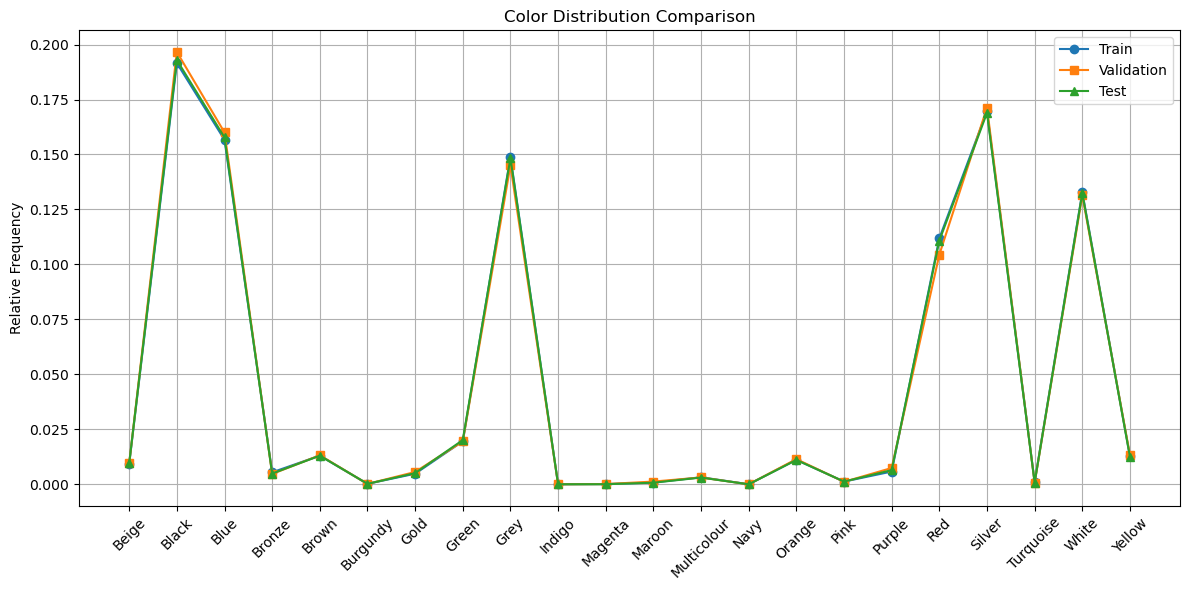

In [33]:
plot_compare_distribution(train_dist=train_dist, val_dist=val_dist, test_dist=test_dist, feature=colors)

# Create datasets that contain distribution shifts

In [34]:
def data_split(df: pd.DataFrame, nclasses: int, split: float) -> np.ndarray:
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  to_fill_size = (int(len(df)*split)-len(critical_ids))
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    # make sure that at least two instances of each class is available. If not, remove the singular classes
    if stratify is not None:
      valid_stratify_labels = stratify.value_counts()[stratify.value_counts() >= 2].index
      valid_stratify = stratify[stratify.isin(valid_stratify_labels)]
      invalid_part = stratify[~stratify.isin(valid_stratify_labels)]
    else:
      valid_stratify = stratify
      invalid_part = None

    if invalid_part is not None:
        valid_other_ids = other_ids[~np.isin(other_ids, invalid_part.index)]
    else:
        valid_other_ids = other_ids

    _, low_data_ids = train_test_split(valid_other_ids, test_size=to_fill_size, random_state=2023, stratify=valid_stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [35]:
def create_shift_mask(df: pd.DataFrame, filters: list[Dict[str, str]], filter_cond: str) -> pd.Series:
    if filter_cond == "and":
        mask = pd.Series(True, index=df.index)
        for f in filters:
            for col, val in f.items():
                mask &= df[col] == val
    elif filter_cond == "or":
        mask = pd.Series(False, index=df.index)
        for f in filters:
            for col, val in f.items():
                mask |= df[col] == val
    else:
        raise ValueError("mode must be either 'and' or 'or'")
    return mask

In [36]:

def create_shifted_splits(df: pd.DataFrame, split: list[Dict[str, Any]], split_cond: str, ratio: list[float], mode: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Creates shifted versions of the given DataFrames. Also normalizes/categorizes the data
    
    Args:
    -----
        df (pd.DataFrame): the original df
        split (list[Dict[str, str]]): The elements that needs to be filtered
        ratio (list[float]): Expects a list containing two float numbers:
                                first: validation size
                                scond: test size
        mode (int): The mode, i.e. if the newly generated test df should contain all split elements and train/val contain everything else (mode==0) or vice versa (mode==1) 
    '''
    mask = create_shift_mask(df=df, filters=split, filter_cond=split_cond)
    
    no_df = df[~mask]
    only_df = df[mask]
 
    if mode == 0:
        test_df = only_df
        
        desired_train_val_size = int(len(test_df) * (1 / ratio[1] - 1))
        desired_train_val_size = min(desired_train_val_size, len(no_df)-1)
        x = desired_train_val_size / len(no_df)
        
        no_ids = data_split(df=no_df, nclasses=no_df["Genmodel_ID"].nunique(), split=x)
        no_data_df = no_df.loc[no_df['Adv_ID'].isin(no_ids)]
        
        desired_val_size = int((len(no_data_df) + len(test_df)) * ratio[0])
        desired_val_size = min(desired_val_size, len(no_data_df))
        
        x_val = desired_val_size / len(no_data_df)
     
        val_ids = data_split(df=no_data_df, nclasses=no_data_df["Genmodel_ID"].nunique(), split=x_val)
        val_df = no_data_df.loc[no_data_df['Adv_ID'].isin(val_ids)]
        train_df = no_data_df.loc[~no_data_df['Adv_ID'].isin(val_ids)]
    elif mode == 1:
        desired_test_size = int((ratio[1] / (1 - ratio[1])) * len(only_df))
        desired_test_size = min(desired_test_size, len(no_df)-1)
        x = desired_test_size / len(no_df)
        
        only_test_ids = data_split(df=no_df, nclasses=no_df["Genmodel_ID"].nunique(), split=x)
        test_df = no_df.loc[no_df['Adv_ID'].isin(only_test_ids)]
        
        desired_val_size = int((len(test_df) + len(only_df)) * ratio[0])
        desired_val_size = min(desired_val_size, len(only_df)-1)
        
        x_val = desired_val_size / len(only_df)
     
        val_ids = data_split(df=only_df, nclasses=only_df["Genmodel_ID"].nunique(), split=x_val)
        val_df = only_df.loc[only_df['Adv_ID'].isin(val_ids)]
        train_df = only_df.loc[~only_df['Adv_ID'].isin(val_ids)]
    else:
        raise ValueError("mode can only be 0 or 1.")
    
    print(f"Shape of train df:\t{train_df.shape}")
    print(f"Shape of val df:\t{val_df.shape}")
    print(f"Shape of test df:\t{test_df.shape}")
    print(f"Total Size: {train_df.shape[0] + val_df.shape[0] + test_df.shape[0]}")
    
    return train_df, val_df, test_df

In [37]:
def categorize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, categorical_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, dict]]:
    # Deep copies to ensure no slice/view issues
    train_df_copy = train_df.copy(deep=True)
    val_df_copy = val_df.copy(deep=True)
    test_df_copy = test_df.copy(deep=True)
    
    category_mappings = {}

    for col in categorical_columns:
        # Combine all categories
        all_categories = pd.Index(
            pd.concat([
                train_df_copy[col],
                val_df_copy[col],
                test_df_copy[col]
            ]).dropna().unique()
        )
        
        # Store the mapping
        mapping = {category: code for code, category in enumerate(all_categories)}
        category_mappings[col] = mapping

        # Assign categories
        for df in (train_df_copy, val_df_copy, test_df_copy):
            df[col] = pd.Categorical(df[col], categories=all_categories)
            df[col] = df[col].cat.codes

    return train_df_copy, val_df_copy, test_df_copy, category_mappings

In [38]:
def normalize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, continuous_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Compute mean and std from training set only
    mean = train_df[continuous_columns].mean()
    std = train_df[continuous_columns].std()

    # use copies for more sanitary workflow
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # Apply normalization using training stats
    train_df_copy[continuous_columns] = (train_df_copy[continuous_columns] - mean) / std
    val_df_copy[continuous_columns] = (val_df_copy[continuous_columns] - mean) / std
    test_df_copy[continuous_columns] = (test_df_copy[continuous_columns] - mean) / std

    return train_df_copy, val_df_copy, test_df_copy

In [39]:
def reorder_df(df: pd.DataFrame, new_order: list[str]) -> pd.DataFrame:
    other_columns = list(set(list(df.columns)) - set(new_order))
    
    new_order = new_order + other_columns
    return df[new_order]

In [40]:
def get_lengths(df_list: list[pd.DataFrame], continuous_columns: list[str], categorical_columns: list[str]) -> Dict[str, int]:
    length = {i: 1 for i in continuous_columns}
    
    max_list = {i: 0 for i in categorical_columns}
    for df in df_list:
        for col in categorical_columns:
            df_col_max = df[col].max()
            max_list[col] = df_col_max if df_col_max > max_list[col] else max_list[col]

    return max_list | length

In [41]:
def create_dist_dfs(df: pd.DataFrame, cols: list[str], fill_values: list[Any] = [], fill: bool = True) -> pd.DataFrame:
    df_color_counts = get_color_counts(df=df)

    df_dist = pd.DataFrame()
    for col in cols:
        if df_dist.empty:
            df_dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
        else:
            dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
            df_dist = pd.concat([df_dist, dist], axis=1)
    
    if fill and len(colors) > 0:
        df_dist = fill_missing_vals(df=df_dist, fill_values=fill_values)
    
    return df_dist

In [42]:
def create_splitted_train(train_df: pd.DataFrame, low_data_split: float, nclasses: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if low_data_split == 1.0:
        return train_df, pd.DataFrame()
    low_train_ids = data_split(df=train_df, nclasses=nclasses, split=low_data_split)
    low_train_df = train_df.loc[train_df['Adv_ID'].isin(low_train_ids)]
    non_low_train_df = train_df.loc[~train_df['Adv_ID'].isin(low_train_ids)]
    return low_train_df, non_low_train_df

In [43]:
def save_lengths(lengths: Dict[str, int], file_name: str, save_directory: str) -> None:
    # save lengths list
    lengths_list = list(lengths.values())
    lengths_path = os.path.join(save_directory, file_name)
    if not os.path.exists(lengths_path):
        torch.save(lengths_list, lengths_path)
        print(f"Saved lengths to {lengths_path}")

In [44]:
def get_paths(series: pd.Series):
  paths = []
  for im_name in series:
      split = im_name.split('$$')
      path = os.path.join(FEATURES, split[0], split[1], split[2], split[3], im_name)
      paths.append(path)
  return paths

def save_dataset(df: pd.DataFrame, save_directory: str, split: str, k: str, keep_cols: list[str], shift_name: str) -> None:
    labels_path = f"labels_{shift_name}_{split}{k}.pt"
    labels_path = os.path.join(SHIFTED_DIR, labels_path)
    labels = df["Genmodel_ID"]
    if not os.path.exists(labels_path):
        torch.save(labels, labels_path)
        print(f"Saved labels to {labels_path}")
    
    
    img_path = f"image_paths_{shift_name}_{split}{k}.pt"
    img_path = os.path.join(SHIFTED_DIR, img_path)
    imgs = df["Image_name"]
    image_paths = get_paths(series=imgs)
    if not os.path.exists(img_path):
        torch.save(image_paths, img_path)
        print(f"Saved image paths to {img_path}")
    
    dvm_features_path = f"dvm_features_{shift_name}_{split}{k}.csv"
    dvm_features_path = os.path.join(SHIFTED_DIR, dvm_features_path)
    data_df = df[keep_cols].reset_index(drop=True)
    if not os.path.exists(dvm_features_path):
        data_df.to_csv(path_or_buf=dvm_features_path, index=True, header=False)
        print(f"Saved DVM Features to {dvm_features_path}")

In [45]:
test = pd.read_csv(os.path.join(FEATURES, "dvm_features_train_noOH_all_views_physical_jittered_50_reordered.csv"))
test

,18,2,1,8,-0.1783733078316861,-0.92266895226365,-0.6657453625150608,0.0663831011894884,0.0128107158367882,1.0927664392633996,-1.4378187042485542,0.9960867218190104,-0.5540098683911732,-1.0598116856916069,-2.4025881216290865,-0.0937250570174116,0.1476457364499894
0,18,5,1,8,-1.918262,-0.387988,-1.914649,-1.875803,0.012811,-0.830929,-0.743407,0.247769,-0.500332,-1.059812,-1.395615,-0.704885,-0.889086
1,2,5,1,1,-0.459000,-0.009598,0.158274,-0.532699,0.012811,-0.830929,0.876887,-0.862641,-0.122699,0.135216,0.618330,-0.435465,-0.370720
2,8,7,1,1,1.443651,2.104451,0.274151,1.206572,0.012811,0.130919,0.645417,-1.159630,0.309097,2.525272,0.618330,0.223179,0.147646
3,1,10,0,1,0.534420,1.503962,1.748372,0.805573,0.012811,-1.311853,-0.511936,1.031164,-0.165857,0.135216,0.618330,0.295115,0.666012
4,18,7,0,1,0.354818,1.191379,0.628222,-0.085803,0.012811,1.092766,-1.206348,1.089626,-0.580984,2.525272,0.618330,-0.415115,0.018054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70559,18,5,1,8,-0.632989,-0.091856,1.059544,-0.781512,0.012811,-0.350005,-1.437819,1.417016,-0.643023,0.135216,-1.395615,-0.740990,-0.889086
70560,20,10,1,1,-0.459000,0.673150,-0.717247,-0.452983,0.012811,-0.350005,0.413946,0.080917,-0.257298,0.135216,0.618330,-0.380487,-0.500312
70561,2,10,0,1,0.775759,0.755408,1.568118,0.730688,0.012811,1.092766,-0.048995,-0.453779,0.295664,0.135216,0.618330,0.361308,0.147646
70562,2,10,0,1,1.196700,2.746068,1.909314,1.423981,0.012811,0.611842,-2.363701,1.183166,-0.446384,0.135216,0.618330,0.980291,1.443561


### Train, Val: No Black. Test: Only Black

In [46]:
continuous_columns = ['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num', 'Entry_price',  'Engine_size', 'Wheelbase','Height','Width','Length']
categorical_columns = ['Color', 'Bodytype', 'Gearbox', 'Fuel_type']

reorder_columns = categorical_columns + continuous_columns

In [47]:
ratio = [0.1, 0.5]
train_no_black_df, val_no_black_df, test_only_black_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"}],
                                                                               split_cond="and",
                                                                               ratio=ratio,
                                                                               mode=0)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_no_black_df, val_no_black_df, test_only_black_df, cat_mapping = categorize(train_df=train_no_black_df,
                                                                    val_df=val_no_black_df,
                                                                    test_df=test_only_black_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_no_black_df, val_no_black_df, test_only_black_df = normalize(train_df=train_no_black_df,
                                                                    val_df=val_no_black_df,
                                                                    test_df=test_only_black_df,
                                                                    continuous_columns=continuous_columns)

train_no_black_df = reorder_df(df=train_no_black_df, new_order=reorder_columns)
val_no_black_df = reorder_df(df=val_no_black_df, new_order=reorder_columns)
test_only_black_df = reorder_df(df=test_only_black_df, new_order=reorder_columns)

display(train_no_black_df)
display(val_no_black_df)
display(test_only_black_df)

Shape of train df:	(27204, 21)
Shape of val df:	(6801, 21)
Shape of test df:	(34005, 21)
Total Size: 68010


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,-0.008249,1.098628,0.861687,-1.159650,7.520528,0.124744,...,8.045729,6.036487,1.599089,1.956540,1.902100,2.113388,10_3$$47,0,0,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...
25,1,0,0,0,-0.008249,-0.848539,1.328186,-1.257617,10.185334,0.124744,...,8.045729,6.036487,2.020563,2.375633,1.791847,2.215261,10_3$$2,0,90,Bentley$$Bentayga$$2018$$Brown$$10_3$$2$$image...
46,2,0,0,1,-0.008249,-0.848539,1.328186,-1.239818,8.854761,0.124744,...,8.045729,3.142858,2.497494,2.173848,1.828598,1.778662,10_3$$40,0,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$40$$ima...
47,3,0,0,0,-0.008249,-1.335331,1.328186,-1.230418,9.819667,0.124744,...,8.045729,3.142858,2.220209,1.444315,1.902100,1.788364,10_3$$42,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$42$$image...
52,3,0,0,1,-0.008249,0.611836,1.328186,-1.224151,9.519548,0.124744,...,8.045729,3.142858,1.632364,2.406677,2.661622,2.064877,10_3$$58,0,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$58$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176395,0,6,2,1,-0.008249,1.098628,-1.470808,2.943439,-0.695154,0.124744,...,-0.256867,0.249230,0.173842,-0.666672,-1.086988,0.527078,96_9$$395,285,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176398,2,6,2,0,-0.008249,-1.822123,-1.470808,0.848990,-0.528791,0.124744,...,-0.256867,-0.040133,0.273665,-0.014750,-0.511221,0.619249,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176402,3,6,2,1,-0.008249,1.098628,-1.470808,3.996304,-0.701609,0.124744,...,-0.256867,0.249230,0.140568,-0.138925,-0.694977,0.420353,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176406,4,6,0,0,-0.008249,-0.848539,-1.937306,1.258931,-0.641585,0.124744,...,-0.161057,0.827956,0.218208,-0.480409,-0.670476,0.517375,96_9$$283,285,315,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,3,0,0,0,-0.008249,-1.335331,0.861687,-0.950632,7.855916,0.124744,...,8.045729,6.036487,1.854192,1.692667,1.583590,1.890237,10_3$$1,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...
66,5,0,0,1,-0.008249,0.611836,1.328186,-1.192816,10.368666,0.124744,...,8.045729,3.142858,2.364397,1.723711,2.367614,1.788364,10_3$$107,0,0,Bentley$$Bentayga$$2018$$Blue$$10_3$$107$$imag...
98,3,0,0,0,-0.008249,-2.308915,1.094937,-1.014280,9.849613,0.124744,...,8.045729,6.036487,1.898558,1.009700,1.877599,2.157047,10_3$$90,0,225,Bentley$$Bentayga$$2017$$Grey$$10_3$$90$$image...
99,6,0,0,1,-0.008249,0.125044,1.094937,-0.917065,8.188975,0.124744,...,8.045729,3.142858,2.153660,1.708189,1.657093,1.793215,10_3$$95,0,45,Bentley$$Bentayga$$2017$$White$$10_3$$95$$imag...
108,3,2,0,0,-0.008249,1.098628,1.328186,-1.200336,10.518393,-1.151018,...,8.357024,3.142858,1.149887,-0.635628,2.208359,0.997634,10_5$$1,1,135,Bentley$$Continental$$2018$$Grey$$10_5$$1$$ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176174,3,6,2,1,-0.008249,-0.361748,-1.004309,4.012097,-0.747725,0.124744,...,-0.256867,0.249230,0.007471,-0.728760,-1.074738,0.628951,96_9$$101,285,90,Volvo$$V50$$2008$$Grey$$96_9$$101$$image_0.jpg
176184,12,6,2,1,-0.008249,0.611836,-1.004309,0.587027,-0.478217,0.124744,...,-0.256867,-0.329495,0.318031,-0.977112,-1.258493,0.692015,96_9$$165,285,270,Volvo$$V50$$2008$$Gold$$96_9$$165$$image_0.jpg
176248,2,6,2,1,-0.008249,0.125044,-1.004309,1.284425,-0.548422,0.124744,...,-0.256867,0.249230,-0.303089,-1.202180,-0.413218,0.420353,96_9$$487,285,0,Volvo$$V50$$2008$$Silver$$96_9$$487$$image_0.jpg
176399,2,6,2,1,-0.008249,0.611836,-1.470808,-0.215155,-0.495186,0.124744,...,-0.256867,0.249230,0.118385,-0.635628,-1.233993,0.590142,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
9,20,0,0,0,-0.008249,-1.335331,0.861687,-0.967202,8.520371,0.124744,...,8.045729,6.036487,1.599089,1.615057,1.840848,1.895088,10_3$$65,0,0,Bentley$$Bentayga$$2016$$Black$$10_3$$65$$imag...
10,20,0,0,0,-0.008249,-1.335331,0.861687,-1.106456,8.488762,0.124744,...,8.045729,6.036487,1.632364,1.366705,1.669343,1.919343,10_3$$67,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$67$$imag...
11,20,0,0,0,-0.008249,0.611836,0.861687,-1.222897,8.179326,0.124744,...,8.045729,6.036487,1.554724,1.413271,2.294111,1.851428,10_3$$68,0,0,Bentley$$Bentayga$$2016$$Black$$10_3$$68$$imag...
12,20,0,0,0,-0.008249,-1.335331,0.861687,-0.814937,7.756763,0.124744,...,8.045729,6.036487,2.109295,2.251458,1.608091,1.987259,10_3$$69,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$69$$imag...
13,20,0,0,0,-0.008249,1.098628,0.861687,-1.087354,7.823309,0.124744,...,8.045729,6.036487,1.587998,1.552969,2.281861,1.778662,10_3$$72,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176361,20,6,2,0,-0.008249,-1.822123,-1.704057,2.492212,-0.695154,0.124744,...,-0.147221,-0.040133,0.550951,-0.542497,-0.768479,0.536780,96_9$$399,285,45,Volvo$$V50$$2005$$Black$$96_9$$399$$image_0.jpg
176372,20,6,2,1,-0.008249,0.125044,-1.470808,1.598530,-0.641585,0.124744,...,-0.256867,0.249230,0.318031,-0.076838,-1.074738,0.221458,96_9$$49,285,45,Volvo$$V50$$2006$$Black$$96_9$$49$$image_0.jpg
176373,20,6,2,1,-0.008249,1.098628,-1.470808,1.865506,-0.641585,0.124744,...,-0.256867,0.249230,0.484402,-0.495931,-0.547972,0.624100,96_9$$66,285,270,Volvo$$V50$$2006$$Black$$96_9$$66$$image_0.jpg
176381,20,6,2,1,-0.008249,-0.361748,-1.470808,0.601366,-0.628276,0.124744,...,-0.256867,0.249230,0.229299,-0.682194,-0.302965,0.628951,96_9$$198,285,45,Volvo$$V50$$2006$$Black$$96_9$$198$$image_0.jpg


In [48]:
genmodel_mapping = cat_mapping["Genmodel_ID"]
genmodel_to_car = unique_cars.set_index('Genmodel_ID')['Car Name'].to_dict()
int_to_car = {v: genmodel_to_car[k] for k, v in genmodel_mapping.items() if k in genmodel_to_car}

int_to_car

{0: 'Bentley Bentayga',
 1: 'Bentley Continental',
 2: 'Chevrolet Spark',
 3: 'Citroen C3 Picasso',
 4: 'Citroen C4',
 5: 'Citroen C4 Cactus',
 6: 'Citroen C4 Picasso',
 7: 'Citroen C5',
 8: 'Citroen Grand C4 Picasso',
 9: 'Citroen Xsara Picasso',
 10: 'Citroen C1',
 11: 'Citroen C2',
 12: 'Citroen C3',
 13: 'Citroen C3 Aircross',
 14: 'Citroen DS3 Cabrio',
 15: 'DS 4',
 16: 'DS 5',
 17: 'Dacia Duster',
 18: 'Dacia Sandero',
 19: 'Ferrari 488',
 20: 'Fiat Bravo',
 21: 'Fiat Doblo',
 22: 'Fiat Grande Punto',
 23: 'Fiat Panda',
 24: 'Fiat Punto',
 25: 'Fiat Punto Evo',
 26: 'Fiat 500',
 27: 'Fiat Tipo',
 28: 'Fiat 500L',
 29: 'Fiat 500X',
 30: 'Ford B-Max',
 31: 'Ford Fiesta',
 32: 'Ford Focus',
 33: 'Ford Focus C-Max',
 34: 'Ford Fusion',
 35: 'Ford Galaxy',
 36: 'Ford Grand C-Max',
 37: 'Ford C-Max',
 38: 'Ford Ka',
 39: 'Ford Kuga',
 40: 'Ford Mondeo',
 41: 'Ford Mustang',
 42: 'Ford S-Max',
 43: 'Ford EcoSport',
 44: 'Ford Edge',
 45: 'Abarth 595',
 46: 'Honda Accord',
 47: 'Honda Ja

In [49]:
lengths = get_lengths(df_list=[train_no_black_df, val_no_black_df, test_only_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)
lengths

{'Color': 20,
 'Bodytype': 11,
 'Gearbox': 2,
 'Fuel_type': 10,
 'Adv_year': 1,
 'Adv_month': 1,
 'Reg_year': 1,
 'Runned_Miles': 1,
 'Price': 1,
 'Seat_num': 1,
 'Door_num': 1,
 'Entry_price': 1,
 'Engine_size': 1,
 'Wheelbase': 1,
 'Height': 1,
 'Width': 1,
 'Length': 1}

In [50]:
k = 0.1
low_train_no_black_df, high_train_no_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,-0.008249,1.098628,0.861687,-1.159650,7.520528,0.124744,...,8.045729,6.036487,1.599089,1.956540,1.902100,2.113388,10_3$$47,0,0,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...
105,4,0,0,1,-0.008249,0.611836,1.094937,-0.932808,8.188642,2.676266,...,8.045729,3.142858,1.787644,1.180442,1.877599,2.195856,10_3$$116,0,225,Bentley$$Bentayga$$2017$$Red$$10_3$$116$$image...
110,3,1,0,0,-0.008249,1.098628,1.328186,-1.242952,11.847635,-1.151018,...,8.357024,6.036487,1.377261,-1.217702,1.552965,1.317807,10_5$$40,1,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...
150,5,1,0,0,-0.008249,1.098628,0.861687,-0.737627,5.191442,-1.151018,...,8.357024,6.036487,0.922513,-1.109048,1.454962,1.351765,10_5$$601,1,0,Bentley$$Continental$$2016$$Blue$$10_5$$601$$i...
163,5,2,0,0,-0.008249,-0.361748,-1.004309,-0.255615,2.865684,-1.151018,...,6.987324,6.036487,0.656319,-1.815298,0.089046,1.356616,10_5$$61,1,0,Bentley$$Continental$$2008$$Blue$$10_5$$61$$im...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176055,5,6,2,1,-0.008249,0.611836,-0.771059,0.718360,-0.428973,0.124744,...,-0.257558,0.249230,0.406762,-0.084599,-1.233993,0.328182,96_9$$370,285,135,Volvo$$V50$$2009$$Blue$$96_9$$370$$image_23.jpg
176057,2,6,2,1,-0.008249,-0.848539,-0.771059,1.256725,-0.528791,0.124744,...,-0.257558,-0.329495,-0.513825,-0.581302,-0.498971,0.236012,96_9$$380,285,0,Volvo$$V50$$2009$$Silver$$96_9$$380$$image_0.jpg
176182,5,6,0,1,-0.008249,0.611836,-1.004309,0.185936,-0.331817,0.124744,...,-0.256867,0.249230,0.495493,0.055099,-0.633725,0.692015,96_9$$157,285,0,Volvo$$V50$$2008$$Blue$$96_9$$157$$image_0.jpg
176284,5,6,2,1,-0.008249,-0.848539,-0.071311,0.921187,-0.262277,0.124744,...,-0.008176,0.249230,0.440036,-0.348472,-0.841981,0.706568,96_9$$285,285,0,Volvo$$V50$$2012$$Blue$$96_9$$285$$image_1.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
25,1,0,0,0,-0.008249,-0.848539,1.328186,-1.257617,10.185334,0.124744,...,8.045729,6.036487,2.020563,2.375633,1.791847,2.215261,10_3$$2,0,90,Bentley$$Bentayga$$2018$$Brown$$10_3$$2$$image...
46,2,0,0,1,-0.008249,-0.848539,1.328186,-1.239818,8.854761,0.124744,...,8.045729,3.142858,2.497494,2.173848,1.828598,1.778662,10_3$$40,0,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$40$$ima...
47,3,0,0,0,-0.008249,-1.335331,1.328186,-1.230418,9.819667,0.124744,...,8.045729,3.142858,2.220209,1.444315,1.902100,1.788364,10_3$$42,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$42$$image...
52,3,0,0,1,-0.008249,0.611836,1.328186,-1.224151,9.519548,0.124744,...,8.045729,3.142858,1.632364,2.406677,2.661622,2.064877,10_3$$58,0,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$58$$image...
61,3,0,0,0,-0.008249,0.611836,1.328186,-1.054940,8.987851,0.124744,...,8.045729,3.142858,2.353306,2.375633,1.534589,1.967854,10_3$$91,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$91$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176389,3,6,2,0,-0.008249,-0.361748,-1.470808,-0.340496,-0.395767,0.124744,...,-0.256867,-0.040133,0.451128,-0.961590,-0.658226,0.624100,96_9$$304,285,225,Volvo$$V50$$2006$$Grey$$96_9$$304$$image_0.jpg
176395,0,6,2,1,-0.008249,1.098628,-1.470808,2.943439,-0.695154,0.124744,...,-0.256867,0.249230,0.173842,-0.666672,-1.086988,0.527078,96_9$$395,285,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176402,3,6,2,1,-0.008249,1.098628,-1.470808,3.996304,-0.701609,0.124744,...,-0.256867,0.249230,0.140568,-0.138925,-0.694977,0.420353,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176406,4,6,0,0,-0.008249,-0.848539,-1.937306,1.258931,-0.641585,0.124744,...,-0.161057,0.827956,0.218208,-0.480409,-0.670476,0.517375,96_9$$283,285,315,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg


In [51]:
save_lengths(lengths=lengths, file_name="tabular_lengths_test_only_black.pt", save_directory=SHIFTED_DIR)

Saved lengths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/tabular_lengths_test_only_black.pt


In [52]:
save_dataset(df=train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="", keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=low_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=high_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=val_no_black_df, save_directory=SHIFTED_DIR, split="val", k="", keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=test_only_black_df, save_directory=SHIFTED_DIR, split="test", k="", keep_cols=reorder_columns, shift_name="no_black")

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_no_black_train.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_no_black_train.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_no_black_train.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_no_black_train_0.1.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_no_black_train_0.1.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_no_black_train_0.1.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_no_black_train_0.9.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_no_black_train_0.9.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_no_black_train_0.9.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_no_black_val.pt
Saved image paths to /mnt/data/kgutjahr

In [53]:
k = 0.01
low_train_no_black_df, high_train_no_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,-0.008249,1.098628,0.861687,-1.159650,7.520528,0.124744,...,8.045729,6.036487,1.599089,1.956540,1.902100,2.113388,10_3$$47,0,0,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...
110,3,1,0,0,-0.008249,1.098628,1.328186,-1.242952,11.847635,-1.151018,...,8.357024,6.036487,1.377261,-1.217702,1.552965,1.317807,10_5$$40,1,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...
820,5,4,2,0,-0.008249,-0.848539,-0.304560,0.244445,-0.614967,0.124744,...,-0.871848,-0.908221,-1.539782,0.326734,-1.240118,-1.495831,16_14$$26,2,0,Chevrolet$$Spark$$2011$$Blue$$16_14$$26$$image...
998,4,5,2,1,-0.008249,-0.848539,0.628438,-0.515974,-0.328822,0.124744,...,-0.457479,-0.329495,-0.114534,0.613890,-0.621475,-0.462547,18_10$$5,3,45,Citroen$$C3 Picasso$$2015$$Red$$18_10$$5$$imag...
1454,3,4,2,1,-0.008249,1.098628,0.161939,-0.466364,-0.354642,0.124744,...,-0.392799,-0.329495,0.207117,-0.643389,-0.333591,-0.081736,18_12$$9,4,225,Citroen$$C4$$2013$$Grey$$18_12$$9$$image_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174818,12,3,0,1,-0.008249,0.125044,-0.304560,0.662232,-0.312386,0.124744,...,0.158540,0.827956,1.155433,0.326734,0.082921,-0.748762,96_4$$8,281,315,Volvo$$S60$$2011$$Gold$$96_4$$8$$image_0.jpg
175237,5,3,0,1,-2.370554,1.585419,-1.004309,1.163596,-0.528458,0.124744,...,0.258500,0.827956,1.665638,-0.720999,0.958822,1.271722,96_5$$19,282,0,Volvo$$S80$$2008$$Blue$$96_5$$19$$image_0.jpg
175344,5,3,0,1,-0.008249,-0.361748,1.328186,-1.221218,1.564724,0.124744,...,1.020828,0.249230,1.876375,-0.829653,1.173203,1.761683,96_6$$11,283,225,Volvo$$S90$$2018$$Blue$$96_6$$11$$image_0.jpg
175486,6,4,2,1,-0.008249,-0.361748,0.161939,0.662232,-0.295550,0.124744,...,-0.038268,-0.329495,-0.075714,-1.372922,1.540714,-0.120544,96_7$$154,284,315,Volvo$$V40$$2013$$White$$96_7$$154$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
25,1,0,0,0,-0.008249,-0.848539,1.328186,-1.257617,10.185334,0.124744,...,8.045729,6.036487,2.020563,2.375633,1.791847,2.215261,10_3$$2,0,90,Bentley$$Bentayga$$2018$$Brown$$10_3$$2$$image...
46,2,0,0,1,-0.008249,-0.848539,1.328186,-1.239818,8.854761,0.124744,...,8.045729,3.142858,2.497494,2.173848,1.828598,1.778662,10_3$$40,0,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$40$$ima...
47,3,0,0,0,-0.008249,-1.335331,1.328186,-1.230418,9.819667,0.124744,...,8.045729,3.142858,2.220209,1.444315,1.902100,1.788364,10_3$$42,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$42$$image...
52,3,0,0,1,-0.008249,0.611836,1.328186,-1.224151,9.519548,0.124744,...,8.045729,3.142858,1.632364,2.406677,2.661622,2.064877,10_3$$58,0,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$58$$image...
61,3,0,0,0,-0.008249,0.611836,1.328186,-1.054940,8.987851,0.124744,...,8.045729,3.142858,2.353306,2.375633,1.534589,1.967854,10_3$$91,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$91$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176395,0,6,2,1,-0.008249,1.098628,-1.470808,2.943439,-0.695154,0.124744,...,-0.256867,0.249230,0.173842,-0.666672,-1.086988,0.527078,96_9$$395,285,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176398,2,6,2,0,-0.008249,-1.822123,-1.470808,0.848990,-0.528791,0.124744,...,-0.256867,-0.040133,0.273665,-0.014750,-0.511221,0.619249,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176402,3,6,2,1,-0.008249,1.098628,-1.470808,3.996304,-0.701609,0.124744,...,-0.256867,0.249230,0.140568,-0.138925,-0.694977,0.420353,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176406,4,6,0,0,-0.008249,-0.848539,-1.937306,1.258931,-0.641585,0.124744,...,-0.161057,0.827956,0.218208,-0.480409,-0.670476,0.517375,96_9$$283,285,315,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg


In [54]:
save_dataset(df=low_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=high_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="no_black")

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_no_black_train_0.01.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_no_black_train_0.01.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_no_black_train_0.01.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_no_black_train_0.99.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_no_black_train_0.99.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_no_black_train_0.99.csv


In [55]:
train_no_black_dist = create_dist_dfs(df=train_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
val_no_black_dist = create_dist_dfs(df=val_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
test_only_black_dist = create_dist_dfs(df=test_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))

display(train_no_black_dist)
display(test_only_black_dist)

2     0.210447
5     0.193501
3     0.185671
6     0.164314
4     0.137480
0     0.025107
1     0.016064
11    0.014961
13    0.013748
9     0.011028
8     0.007719
12    0.006396
10    0.006249
14    0.003345
16    0.001470
7     0.001140
15    0.001066
18    0.000184
17    0.000074
19    0.000037
20    0.000000
Name: Count, dtype: float64

20    1.0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: Count, dtype: float64

In [56]:
train_test_kl_no_black = calc_JS(first_dist=train_no_black_dist, second_dist=test_only_black_dist)
train_test_kl_no_black

0.6430883636589323

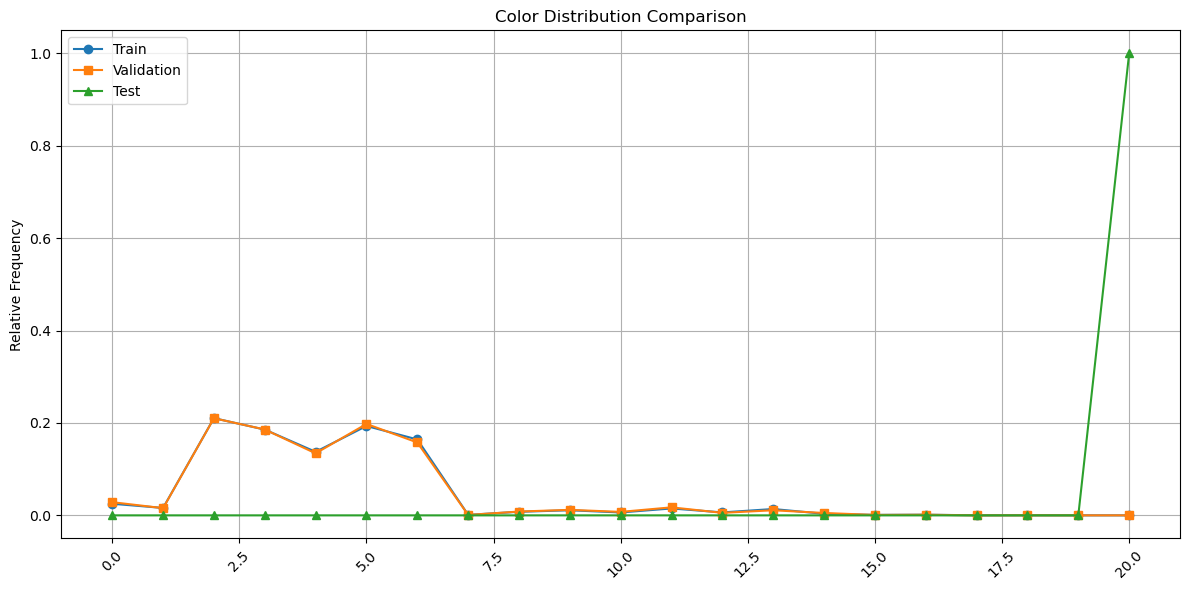

In [57]:
plot_compare_distribution(train_dist=train_no_black_dist, val_dist=val_no_black_dist, test_dist=test_only_black_dist, feature=list(range(lengths["Color"]+1)))

### Train, Val: Only Black. Test: No Black

In [58]:
ratio = [0.1, 0.5]
train_only_black_df, val_only_black_df, test_no_black_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"}],
                                                                               split_cond="and",
                                                                               ratio=ratio,
                                                                               mode=1)

train_only_black_df, val_only_black_df, test_no_black_df, cat_mapping = categorize(train_df=train_only_black_df,
                                                                    val_df=val_only_black_df,
                                                                    test_df=test_no_black_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_only_black_df, val_only_black_df, test_no_black_df = normalize(train_df=train_only_black_df,
                                                                    val_df=val_only_black_df,
                                                                    test_df=test_no_black_df,
                                                                    continuous_columns=continuous_columns)

train_only_black_df = reorder_df(df=train_only_black_df, new_order=reorder_columns)
val_only_black_df = reorder_df(df=val_only_black_df, new_order=reorder_columns)
test_no_black_df = reorder_df(df=test_no_black_df, new_order=reorder_columns)

Shape of train df:	(27204, 21)
Shape of val df:	(6801, 21)
Shape of test df:	(34005, 21)
Total Size: 68010


In [59]:
genmodel_mapping = cat_mapping["Genmodel_ID"]
genmodel_to_car = unique_cars.set_index('Genmodel_ID')['Car Name'].to_dict()
int_to_car = {v: genmodel_to_car[k] for k, v in genmodel_mapping.items() if k in genmodel_to_car}

int_to_car

{0: 'Bentley Bentayga',
 1: 'Bentley Continental',
 2: 'Chevrolet Spark',
 3: 'Citroen C3 Picasso',
 4: 'Citroen C4',
 5: 'Citroen C4 Cactus',
 6: 'Citroen C4 Picasso',
 7: 'Citroen C5',
 8: 'Citroen Grand C4 Picasso',
 9: 'Citroen Xsara Picasso',
 10: 'Citroen C1',
 11: 'Citroen C2',
 12: 'Citroen C3',
 13: 'Citroen C3 Aircross',
 14: 'Citroen DS3 Cabrio',
 15: 'DS 4',
 16: 'DS 5',
 17: 'Dacia Duster',
 18: 'Dacia Sandero',
 19: 'Ferrari 488',
 20: 'Fiat Bravo',
 21: 'Fiat Doblo',
 22: 'Fiat Grande Punto',
 23: 'Fiat Panda',
 24: 'Fiat Punto',
 25: 'Fiat Punto Evo',
 26: 'Fiat 500',
 27: 'Fiat Tipo',
 28: 'Fiat 500L',
 29: 'Fiat 500X',
 30: 'Ford B-Max',
 31: 'Ford Fiesta',
 32: 'Ford Focus',
 33: 'Ford Focus C-Max',
 34: 'Ford Fusion',
 35: 'Ford Galaxy',
 36: 'Ford Grand C-Max',
 37: 'Ford C-Max',
 38: 'Ford Ka',
 39: 'Ford Kuga',
 40: 'Ford Mondeo',
 41: 'Ford Mustang',
 42: 'Ford S-Max',
 43: 'Ford EcoSport',
 44: 'Ford Edge',
 45: 'Abarth 595',
 46: 'Honda Accord',
 47: 'Honda Ja

In [60]:
lengths = get_lengths(df_list=[train_only_black_df, val_only_black_df, test_no_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)
lengths

{'Color': 20,
 'Bodytype': 11,
 'Gearbox': 2,
 'Fuel_type': 10,
 'Adv_year': 1,
 'Adv_month': 1,
 'Reg_year': 1,
 'Runned_Miles': 1,
 'Price': 1,
 'Seat_num': 1,
 'Door_num': 1,
 'Entry_price': 1,
 'Engine_size': 1,
 'Wheelbase': 1,
 'Height': 1,
 'Width': 1,
 'Length': 1}

In [61]:
k = 0.1
low_train_only_black_df, high_train_only_black_df = create_splitted_train(train_df=train_only_black_df, low_data_split=k, nclasses=train_only_black_df["Genmodel_ID"].nunique())
display(low_train_only_black_df)
display(high_train_no_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
10,0,0,0,0,-0.001939,-1.342745,0.919387,-1.189998,7.719122,0.121833,...,6.639788,4.896624,1.352642,1.208427,1.580615,1.673371,10_3$$67,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$67$$imag...
33,0,0,0,0,-2.399088,2.042122,1.402579,-1.347299,13.858988,0.121833,...,6.639788,4.896624,1.686484,1.322755,2.420238,1.917417,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
50,0,0,0,1,-0.001939,-1.826297,1.402579,-1.304075,9.885954,0.121833,...,6.639788,2.460783,1.423457,1.394210,1.446762,1.682580,10_3$$49,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$49$$imag...
111,0,1,0,0,-0.001939,1.075017,1.402579,-1.322494,11.752974,-1.063976,...,6.903311,4.896624,1.099731,-0.599388,1.769226,1.153044,10_5$$122,1,90,Bentley$$Continental$$2018$$Black$$10_5$$122$$...
131,0,2,0,0,-0.001939,0.591465,0.919387,-1.114552,6.832524,-1.063976,...,6.903311,4.896624,0.710249,-1.421121,1.452846,1.019509,10_5$$55,1,45,Bentley$$Continental$$2016$$Black$$10_5$$55$$i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176086,0,6,1,1,-0.001939,-0.375640,-0.288594,2.154534,-0.605913,0.121833,...,-0.281194,-0.462226,0.184196,-0.399313,-1.254634,0.121601,96_9$$5,284,0,Volvo$$V50$$2011$$Black$$96_9$$5$$image_0.jpg
176167,0,6,0,1,-0.001939,0.591465,-1.013382,1.598811,-0.593994,0.121833,...,-0.388653,0.024942,-0.078831,-1.142447,-1.157287,0.434717,96_9$$79,284,315,Volvo$$V50$$2008$$Black$$96_9$$79$$image_0.jpg
176216,0,6,1,1,-0.001939,1.075017,-1.013382,1.529407,-0.624556,0.121833,...,-0.388653,0.024942,-0.240694,-0.720861,-1.072108,0.112391,96_9$$322,284,0,Volvo$$V50$$2008$$Black$$96_9$$322$$image_0.jpg
176241,0,6,1,1,-0.001939,-1.342745,-1.013382,2.384702,-0.624556,0.121833,...,-0.388653,0.512110,0.275243,-1.228193,-0.901749,0.434717,96_9$$461,284,0,Volvo$$V50$$2008$$Black$$96_9$$461$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
25,1,0,0,0,-0.008249,-0.848539,1.328186,-1.257617,10.185334,0.124744,...,8.045729,6.036487,2.020563,2.375633,1.791847,2.215261,10_3$$2,0,90,Bentley$$Bentayga$$2018$$Brown$$10_3$$2$$image...
46,2,0,0,1,-0.008249,-0.848539,1.328186,-1.239818,8.854761,0.124744,...,8.045729,3.142858,2.497494,2.173848,1.828598,1.778662,10_3$$40,0,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$40$$ima...
47,3,0,0,0,-0.008249,-1.335331,1.328186,-1.230418,9.819667,0.124744,...,8.045729,3.142858,2.220209,1.444315,1.902100,1.788364,10_3$$42,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$42$$image...
52,3,0,0,1,-0.008249,0.611836,1.328186,-1.224151,9.519548,0.124744,...,8.045729,3.142858,1.632364,2.406677,2.661622,2.064877,10_3$$58,0,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$58$$image...
61,3,0,0,0,-0.008249,0.611836,1.328186,-1.054940,8.987851,0.124744,...,8.045729,3.142858,2.353306,2.375633,1.534589,1.967854,10_3$$91,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$91$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176395,0,6,2,1,-0.008249,1.098628,-1.470808,2.943439,-0.695154,0.124744,...,-0.256867,0.249230,0.173842,-0.666672,-1.086988,0.527078,96_9$$395,285,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176398,2,6,2,0,-0.008249,-1.822123,-1.470808,0.848990,-0.528791,0.124744,...,-0.256867,-0.040133,0.273665,-0.014750,-0.511221,0.619249,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176402,3,6,2,1,-0.008249,1.098628,-1.470808,3.996304,-0.701609,0.124744,...,-0.256867,0.249230,0.140568,-0.138925,-0.694977,0.420353,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176406,4,6,0,0,-0.008249,-0.848539,-1.937306,1.258931,-0.641585,0.124744,...,-0.161057,0.827956,0.218208,-0.480409,-0.670476,0.517375,96_9$$283,285,315,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg


In [62]:
save_lengths(lengths=lengths, file_name="tabular_lengths_test_only_black.pt", save_directory=SHIFTED_DIR)

In [63]:
save_dataset(df=train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="", keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=low_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=high_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=val_only_black_df, save_directory=SHIFTED_DIR, split="val", k="", keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=test_no_black_df, save_directory=SHIFTED_DIR, split="test", k="", keep_cols=reorder_columns, shift_name="only_black")

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_only_black_train.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_only_black_train.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_only_black_train.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_only_black_train_0.1.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_only_black_train_0.1.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_only_black_train_0.1.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_only_black_train_0.9.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_only_black_train_0.9.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_only_black_train_0.9.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_only_black_val.pt
Saved image paths t

In [64]:
k = 0.01
low_train_only_black_df, high_train_only_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,-0.008249,1.098628,0.861687,-1.159650,7.520528,0.124744,...,8.045729,6.036487,1.599089,1.956540,1.902100,2.113388,10_3$$47,0,0,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...
110,3,1,0,0,-0.008249,1.098628,1.328186,-1.242952,11.847635,-1.151018,...,8.357024,6.036487,1.377261,-1.217702,1.552965,1.317807,10_5$$40,1,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...
820,5,4,2,0,-0.008249,-0.848539,-0.304560,0.244445,-0.614967,0.124744,...,-0.871848,-0.908221,-1.539782,0.326734,-1.240118,-1.495831,16_14$$26,2,0,Chevrolet$$Spark$$2011$$Blue$$16_14$$26$$image...
998,4,5,2,1,-0.008249,-0.848539,0.628438,-0.515974,-0.328822,0.124744,...,-0.457479,-0.329495,-0.114534,0.613890,-0.621475,-0.462547,18_10$$5,3,45,Citroen$$C3 Picasso$$2015$$Red$$18_10$$5$$imag...
1454,3,4,2,1,-0.008249,1.098628,0.161939,-0.466364,-0.354642,0.124744,...,-0.392799,-0.329495,0.207117,-0.643389,-0.333591,-0.081736,18_12$$9,4,225,Citroen$$C4$$2013$$Grey$$18_12$$9$$image_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174818,12,3,0,1,-0.008249,0.125044,-0.304560,0.662232,-0.312386,0.124744,...,0.158540,0.827956,1.155433,0.326734,0.082921,-0.748762,96_4$$8,281,315,Volvo$$S60$$2011$$Gold$$96_4$$8$$image_0.jpg
175237,5,3,0,1,-2.370554,1.585419,-1.004309,1.163596,-0.528458,0.124744,...,0.258500,0.827956,1.665638,-0.720999,0.958822,1.271722,96_5$$19,282,0,Volvo$$S80$$2008$$Blue$$96_5$$19$$image_0.jpg
175344,5,3,0,1,-0.008249,-0.361748,1.328186,-1.221218,1.564724,0.124744,...,1.020828,0.249230,1.876375,-0.829653,1.173203,1.761683,96_6$$11,283,225,Volvo$$S90$$2018$$Blue$$96_6$$11$$image_0.jpg
175486,6,4,2,1,-0.008249,-0.361748,0.161939,0.662232,-0.295550,0.124744,...,-0.038268,-0.329495,-0.075714,-1.372922,1.540714,-0.120544,96_7$$154,284,315,Volvo$$V40$$2013$$White$$96_7$$154$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
25,1,0,0,0,-0.008249,-0.848539,1.328186,-1.257617,10.185334,0.124744,...,8.045729,6.036487,2.020563,2.375633,1.791847,2.215261,10_3$$2,0,90,Bentley$$Bentayga$$2018$$Brown$$10_3$$2$$image...
46,2,0,0,1,-0.008249,-0.848539,1.328186,-1.239818,8.854761,0.124744,...,8.045729,3.142858,2.497494,2.173848,1.828598,1.778662,10_3$$40,0,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$40$$ima...
47,3,0,0,0,-0.008249,-1.335331,1.328186,-1.230418,9.819667,0.124744,...,8.045729,3.142858,2.220209,1.444315,1.902100,1.788364,10_3$$42,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$42$$image...
52,3,0,0,1,-0.008249,0.611836,1.328186,-1.224151,9.519548,0.124744,...,8.045729,3.142858,1.632364,2.406677,2.661622,2.064877,10_3$$58,0,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$58$$image...
61,3,0,0,0,-0.008249,0.611836,1.328186,-1.054940,8.987851,0.124744,...,8.045729,3.142858,2.353306,2.375633,1.534589,1.967854,10_3$$91,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$91$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176395,0,6,2,1,-0.008249,1.098628,-1.470808,2.943439,-0.695154,0.124744,...,-0.256867,0.249230,0.173842,-0.666672,-1.086988,0.527078,96_9$$395,285,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176398,2,6,2,0,-0.008249,-1.822123,-1.470808,0.848990,-0.528791,0.124744,...,-0.256867,-0.040133,0.273665,-0.014750,-0.511221,0.619249,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176402,3,6,2,1,-0.008249,1.098628,-1.470808,3.996304,-0.701609,0.124744,...,-0.256867,0.249230,0.140568,-0.138925,-0.694977,0.420353,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176406,4,6,0,0,-0.008249,-0.848539,-1.937306,1.258931,-0.641585,0.124744,...,-0.161057,0.827956,0.218208,-0.480409,-0.670476,0.517375,96_9$$283,285,315,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg


In [65]:
save_dataset(df=low_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=high_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="only_black")

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_only_black_train_0.01.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_only_black_train_0.01.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_only_black_train_0.01.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/labels_only_black_train_0.99.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/image_paths_only_black_train_0.99.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/dvm_features_only_black_train_0.99.csv


In [66]:
train_only_black_dist = create_dist_dfs(df=train_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
val_only_black_dist = create_dist_dfs(df=val_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
test_no_black_dist = create_dist_dfs(df=test_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))

In [67]:
train_test_kl_only_black = calc_JS(first_dist=train_only_black_dist, second_dist=test_no_black_dist)
train_test_kl_only_black

0.6431133649699525

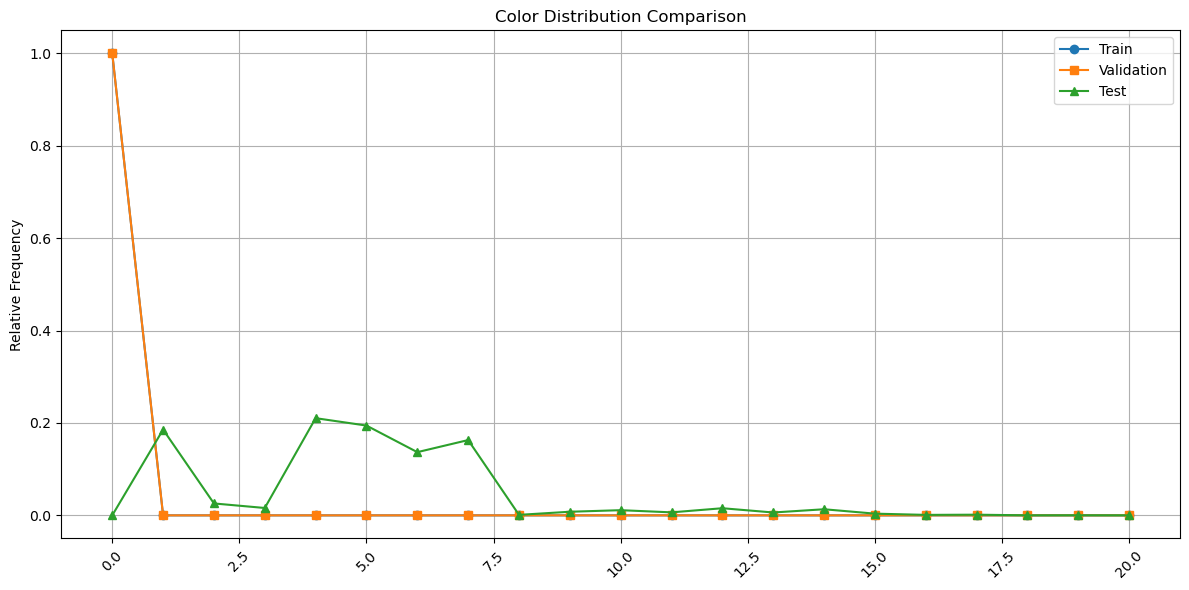

In [69]:
plot_compare_distribution(train_dist=train_only_black_dist, val_dist=val_only_black_dist, test_dist=test_no_black_dist, feature=list(range(lengths["Color"]+1)))

Jensen-Shannon Divergence: 0.12441396285971798
KL-Divergence: 0.06320221328436278


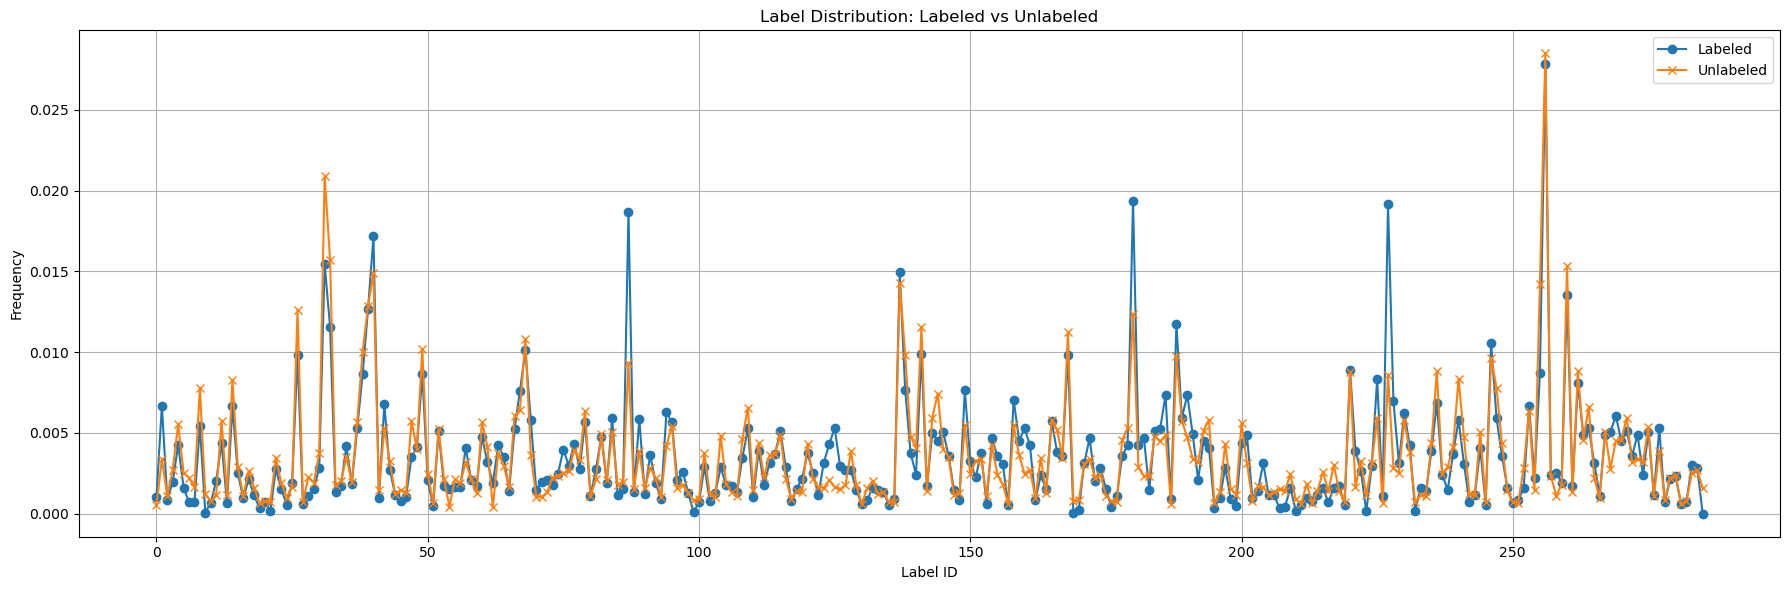

In [76]:
all_lables_path = os.path.join(SHIFTED_DIR, "labels_only_black_train.pt")
all_unlables_path = os.path.join(SHIFTED_DIR, "labels_only_black_test.pt")

label_data = torch.load(all_lables_path, map_location='cpu')

unlabel_data = torch.load(all_unlables_path, map_location='cpu')

from collections import Counter
label_counts = Counter(label_data)
unlabel_counts = Counter(unlabel_data)

# Get sorted list of all label IDs (for alignment)
all_labels = sorted(set(label_counts.keys()) | set(unlabel_counts.keys()))

# Create aligned frequency arrays
label_freqs = np.array([label_counts.get(l, 0) for l in all_labels])
unlabel_freqs = np.array([unlabel_counts.get(l, 0) for l in all_labels])

label_freqs_norm = label_freqs / label_freqs.sum()
unlabel_freqs_norm = unlabel_freqs / unlabel_freqs.sum()

print(f"Jensen-Shannon Divergence: {jensenshannon(label_freqs_norm, unlabel_freqs_norm)}")
print(f"KL-Divergence: {sum(kl_div(label_freqs_norm, unlabel_freqs_norm))}")


plt.figure(figsize=(18, 6))
plt.plot(all_labels, label_freqs_norm, label="Labeled", marker='o')
plt.plot(all_labels, unlabel_freqs_norm, label="Unlabeled", marker='x')
plt.title("Label Distribution: Labeled vs Unlabeled")
plt.xlabel("Label ID")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()